## About this data

Source: Chinese Glioma Genome Atlas (CGGA) at https://www.cgga.org.cn/download.jsp

Data collection: The CGGA is an open-source data portal for the storage of cross-omics data on primary and recurrent glioma samples. Two sets from the DataSetID "mRNAseq_693" were downloaded: Clincal Data and mRNA Expression Data(from STAR+RSEM).

Citation: Zhao, Z., Zhang, KN., Wang, QW., et al. Chinese Glioma Genome Atlas (CGGA): A Comprehensive Resource with Functional Genomic Data from Chinese Glioma Patients (2021). Genomics, Proteomics & Bioinformatics 19(1):1-12.




### Part 1: Clean the clinical data

This data will be used to explore the following questions:
- What clinical factors can predict if a patient survives?
- What associations exist between patient demographics and brain tumor type?
- How do gene expression levels correlate to tumor aggressiveness? (once this data is paired with genomic data)

Raw Attributes and descriptions:
- CGGA_ID: unique sample identifier
- PRS_type: primary vs recurrent tumor classification
- Histology: type of tumor
- Grade: severity of tumor development
- Gender: patient gender
- Age: patient age
- OS: days survived, since last check up
- Censor(alive = 0, dead = 1): survival status
- Radio_status(treated=1;un-treated=0): radiation treatment received
- Chemo_status (TMZ treated=1;un-treated=0): chemotherapy treatment received
- IDH_mutation_status: status of the Isocitrate Dehydrogenase (IDH) gene mutation. Wildtype: No mutation in IDH (more aggressive gliomas)Mutant: Mutated IDH (associated with better prognosis)
- 1p19q_codeletion_status: the co-deletion of chromosomal arms 1p and 19q, which is a marker for certain gliomas. Codel: 1p/19q co-deletion present (better prognosis, common in oligodendrogliomas) Non-codel: no 1p/19q co-deletion (less favorable prognosis)
- MGMTp_methylation_status: O6-Methylguanine-DNA Methyltransferase (MGMT) promoter methylation status. Methylated: Better response to Temozolomide (TMZ) chemotherapy. Un-methylated: Poorer response to TMZ

Each of these attributes are examined and cleaned below.

In [254]:
## import packages for cleaning and EDA
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt

In [255]:
## load data and examine head of data
filename = "CGGA_693_clinical.txt"
df = pd.read_csv(filename, sep='\t')
df.head()


,CGGA_ID,PRS_type,Histology,Grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,CGGA_1002,Primary,AA,WHO III,Female,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,CGGA_1003,Primary,O,WHO II,Female,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,CGGA_1010,Primary,A,WHO II,Male,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,CGGA_1012,Recurrent,rO,WHO II,Male,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,CGGA_1014,Primary,A,WHO II,Male,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [256]:
## rename ID column
df = df.rename(columns={"CGGA_ID": "sample_id"})

## remove 'CGGA_' in ID for readability
df['sample_id'] = df['sample_id'].str.slice(5)

df.head()



,sample_id,PRS_type,Histology,Grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,Primary,AA,WHO III,Female,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,Primary,O,WHO II,Female,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,Primary,A,WHO II,Male,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,Recurrent,rO,WHO II,Male,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,Primary,A,WHO II,Male,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [257]:
#save changes
df_1 = df.copy()

df_1.head()

,sample_id,PRS_type,Histology,Grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,Primary,AA,WHO III,Female,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,Primary,O,WHO II,Female,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,Primary,A,WHO II,Male,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,Recurrent,rO,WHO II,Male,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,Primary,A,WHO II,Male,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [258]:
## rename PRS_type column
df_1 = df_1.rename(columns={"PRS_type": "tumor_type"})


In [259]:
## explore attribute
df_1["tumor_type"].value_counts(dropna=False)

tumor_type
Primary      422
Recurrent    271
Name: count, dtype: int64

In [260]:
# no NA values to handle
# remap categories to P and R, for primary and recurrent
# may remap to 0 and 1 later for modeling purposes
# create remapping dictonary
tumor_type_mapping = {'Primary': 'P', 'Recurrent': 'R'}

# replace values in the 'tumor_type' column
df_1['tumor_type'] = df_1['tumor_type'].replace(tumor_type_mapping)


In [261]:
#save changes in new df
df_2 = df_1.copy()
df_2.head()

,sample_id,tumor_type,Histology,Grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,P,AA,WHO III,Female,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,P,O,WHO II,Female,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,P,A,WHO II,Male,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,R,rO,WHO II,Male,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,P,A,WHO II,Male,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


/Users/julianazweng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


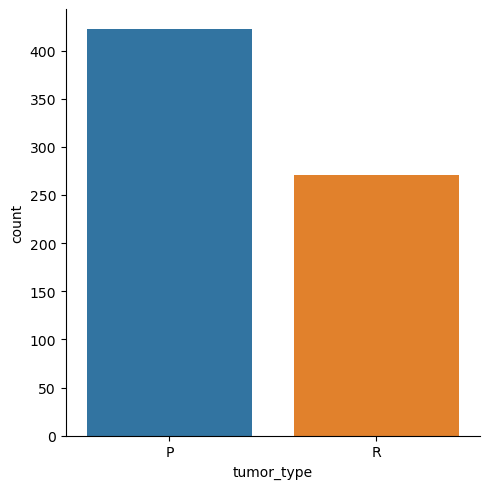

In [262]:
# check for balance of tumor types
sns.catplot(data=df_2, x="tumor_type", kind="count")
# it is balanced enough

In [263]:
## rename Histology column
df_2 = df_2.rename(columns={"Histology": "tumor_histology"})

## explore attribute and check if NA values
df_2["tumor_histology"].value_counts(dropna=False)

tumor_histology
GBM     140
rGBM    109
A        85
AA       82
rAA      70
AO       46
O        45
rAO      36
rA       34
AOA      16
rO       15
OA        8
rAOA      5
NaN       1
rOA       1
Name: count, dtype: int64

Notes for histology column: 

I remapped the histology categories to the full names for understanding, until I gain efficient understanding of the abbreviations.Eventually, I may revert to abbreviations or remap to numbers (indicated below) for modeling.


Primary and recurrent tumors of the same histology will be combined, because the tumor_type column already indicates primary vs recurrent, so this information is redundant. "OA" and "AO" are both common abbreviates for an oligoastrocytoma and will be combined. 

Histology keys:

GBM = glioblastoma multiforme = 0

A = astrocytoma = 1

AA = anaplastic astrocyma = 2

OA/AO = oligoastrocytoma = 3

AOA = anaplastic oligoastrocytoma = 4

O = oligodendroglioma = 5


rGBM = recurrent glioblastoma multiforme = 0

rA = recurrent astrocytoma = 1

rAA = recurrent anaplastic astrocyma = 2

rOA/rAO = recurrent oligoastrocytoma = 3

rAOA = recurrent anaplastic oligoastrocytoma = 4

rO = recurrent oligodendroglioma = 5


In [264]:
tumor_histology_mapping = {'GBM': 'glioblastoma', 'rGBM': 'glioblastoma', 'A':'astrocytoma','rA':'astrocytoma','AA':'anaplastic astrocyma',
                           'rAA' :'anaplastic astrocyma', 'AO':'oligoastrocytoma','rAO':'oligoastrocytoma','OA':'oligoastrocytoma',
                           'rOA':'oligoastrocytoma', 'AOA':'anaplastic oligoastrocytoma','rAOA':'anaplastic oligoastrocytoma','O':'oligodendroglioma', 'rO':'oligodendroglioma' }


# replace values in the 'tumor_type' column
df_2['tumor_histology'] = df_2['tumor_histology'].replace(tumor_histology_mapping)

df_2.head()

,sample_id,tumor_type,tumor_histology,Grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,P,anaplastic astrocyma,WHO III,Female,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,P,oligodendroglioma,WHO II,Female,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,P,astrocytoma,WHO II,Male,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,R,oligodendroglioma,WHO II,Male,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,P,astrocytoma,WHO II,Male,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [265]:
#save changes in new df
df_3 = df_2.copy()

In [266]:
## only 1 Nan value, drop row

df_3 = df_3.dropna(subset = ['tumor_histology'])

#check that NA was dropped
df_3["tumor_histology"].value_counts(dropna=False)


tumor_histology
glioblastoma                   249
anaplastic astrocyma           152
astrocytoma                    119
oligoastrocytoma                91
oligodendroglioma               60
anaplastic oligoastrocytoma     21
Name: count, dtype: int64

In [267]:
#invesitgate grade attribute
df_3["Grade"].value_counts(dropna=False)

#data is balanced, will rename column and remap categories to "2","3", and "4"

Grade
WHO III    255
WHO IV     249
WHO II     188
Name: count, dtype: int64

In [268]:
#rename column
df_3 = df_3.rename(columns={"Grade": "tumor_grade"})

In [269]:
#remap categories

tumor_grade_mapping = {'WHO III': '3', 'WHO II': '2', 'WHO IV':'4'}


# replace values in the 'tumor_type' column
df_3['tumor_grade'] = df_3['tumor_grade'].replace(tumor_grade_mapping)

#save changes
df_4= df_3.copy()
df_4.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,P,anaplastic astrocyma,3,Female,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,P,oligodendroglioma,2,Female,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,P,astrocytoma,2,Male,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,R,oligodendroglioma,2,Male,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,P,astrocytoma,2,Male,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [270]:
#invesitgate gender attribute
df_4["Gender"].value_counts(dropna=False)

#data is balanced, will rename column and combine all data into two categories: M and F

Gender
Male       393
Female     289
Female       5
Male         4
Male         1
Name: count, dtype: int64

In [271]:
#rename column
df_4 = df_4.rename(columns={"Gender": "gender"})

In [272]:
#remap categories, a few data entries have extra spaces after 'Male' or 'Female'

gender_mapping = {'Male': 'M', 'Male ': 'M', 'Male  ':'M', 'Female':'F', 'Female ':'F'}


# replace values in the 'tumor_type' column
df_4['gender'] = df_4['gender'].replace(gender_mapping)

#save changes
df_5= df_4.copy()
df_5.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [273]:
#check that only 2 categories remain
df_5["gender"].value_counts(dropna=False)

gender
M    398
F    294
Name: count, dtype: int64

In [274]:
#invesitgate age attribute, this is the first quantitative attribute, must check for outliers
df_5["Age"].value_counts(dropna=False)

Age
45.0    34
41.0    31
40.0    27
47.0    24
30.0    24
        ..
71.0     1
76.0     1
11.0     1
17.0     1
NaN      1
Name: count, Length: 65, dtype: int64

In [275]:
#rename column
df_5 = df_5.rename(columns={"Age": "age"})

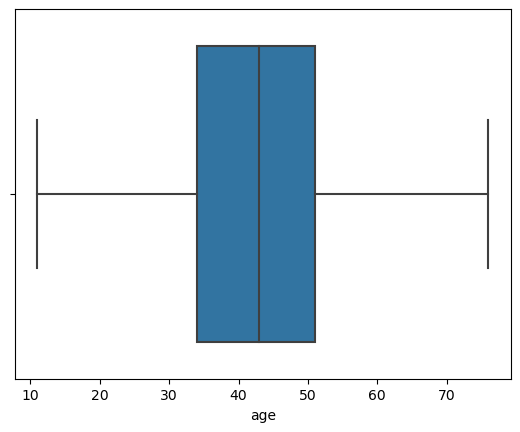

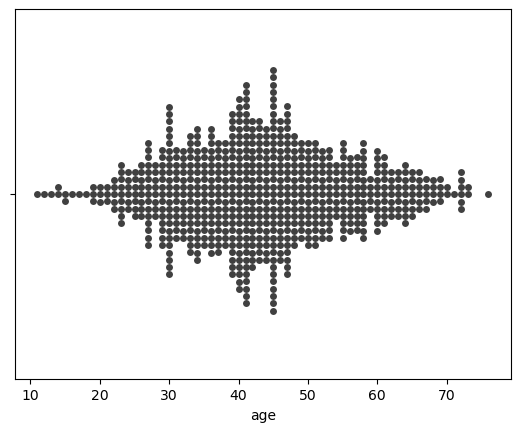

In [276]:
#visualize raw data
plot1=sns.boxplot(x="age",data=df_5)
plt.show()
plot2=sns.swarmplot(x="age",  data=df_5, color=".25")
plt.show()
#plots are reasonable, no outliers to remove


In [277]:
## only 1 Nan value, drop row

df_5 = df_5.dropna(subset = ['age'])

In [278]:
#check Na removal so far, first 6 attributes should have 0 Na values
print(df_5.isnull().sum())

sample_id                                      0
tumor_type                                     0
tumor_histology                                0
tumor_grade                                    0
gender                                         0
age                                            0
OS                                            35
Censor (alive=0; dead=1)                      29
Radio_status (treated=1;un-treated=0)         46
Chemo_status (TMZ treated=1;un-treated=0)     45
IDH_mutation_status                           51
1p19q_codeletion_status                       70
MGMTp_methylation_status                     150
dtype: int64


In [279]:
#based on Na values moving forward, there is no way to impute survival status 
# and this is will be a label for supervised learning, so these Nas will be dropped
#which will likely account for some Na values for other attributes, then those will be handled

#first, rename censor survival column
df_5 = df_5.rename(columns={"Age": "age"})
df_5 = df_5.rename(columns = {'Censor (alive=0; dead=1)': 'survival_status'})

df_5.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,OS,survival_status,Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mutation_status,1p19q_codeletion_status,MGMTp_methylation_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


In [280]:
df_5.shape
#while dropping rows is not ideal, this is necessary and is only 29/691 values
df_5 = df_5.dropna(subset = ['survival_status'])

#check reamining NA values in data
print(df_5.isnull().sum())
#this helped reduce NA values in other columns as well

sample_id                                      0
tumor_type                                     0
tumor_histology                                0
tumor_grade                                    0
gender                                         0
age                                            0
OS                                             6
survival_status                                0
Radio_status (treated=1;un-treated=0)         25
Chemo_status (TMZ treated=1;un-treated=0)     22
IDH_mutation_status                           48
1p19q_codeletion_status                       66
MGMTp_methylation_status                     139
dtype: int64


In [281]:
# check that survival is balanced and only survival categories are 0 and 1
df_5["survival_status"].value_counts(dropna=False)

survival_status
1.0    397
0.0    265
Name: count, dtype: int64

In [282]:
#"OS" is the number of survival days. if they are dead, this is the number of days from diagnosis to death
#if they are still alive, this is the number of days from diagnosis to the last check up

df_5 = df_5.rename(columns = {'OS': 'survival_days'})


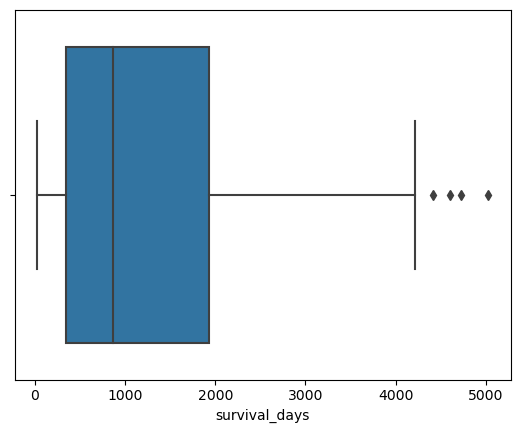

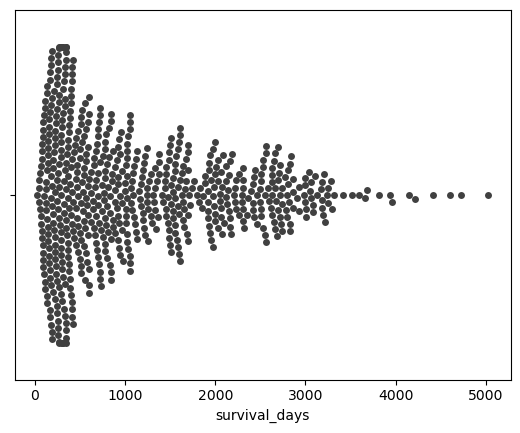

In [283]:
#there are 6 remaining NA values, that will be imputed with mean or median survival days of alive and deceased patients respectively
#visualize raw data to confirm that this approach is reasonable
plot3=sns.boxplot(x="survival_days",data=df_5)
plt.show()
plot4=sns.swarmplot(x="survival_days",  data=df_5, color=".25")
plt.show()


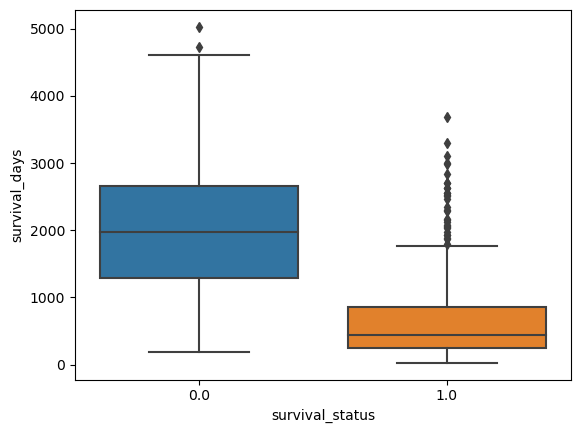

/Users/julianazweng/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 21.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


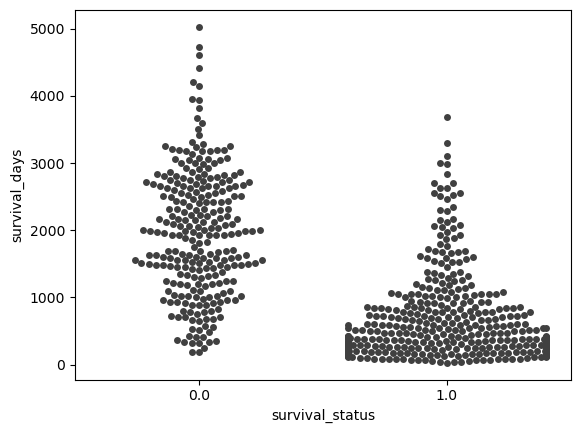

In [284]:
plot5=sns.boxplot(y="survival_days", x = 'survival_status',data=df_5)
plt.show()
plot6=sns.swarmplot(y="survival_days", x = 'survival_status',  data=df_5, color=".25")
plt.show()

In [285]:
# plots show a significant difference in survival days between alive and deceased patients
# will impute with median values of survival_days for each group of NA value corresponding to survival_status

#caluculate median values
survived_df = df_5[df_5['survival_status'] == 0]
deceased_df = df_5[df_5['survival_status'] == 1]
survived_median_days = survived_df['survival_days'].median()
print(survived_median_days)
deceased_median_days = deceased_df['survival_days'].median()
print(deceased_median_days)


1978.0
445.5


In [286]:
# impute median values to survival_days according to survival status
import pandas as pd

df_5.loc[(df_5['survival_status'] == 0) & (pd.isna(df_5['survival_days'])), 'survival_days'] = survived_median_days
df_5.loc[(df_5['survival_status'] == 1) & (pd.isna(df_5['survival_days'])), 'survival_days'] = deceased_median_days



In [287]:
#check that NAs are replaced
print(df_5.isnull().sum())

sample_id                                      0
tumor_type                                     0
tumor_histology                                0
tumor_grade                                    0
gender                                         0
age                                            0
survival_days                                  0
survival_status                                0
Radio_status (treated=1;un-treated=0)         25
Chemo_status (TMZ treated=1;un-treated=0)     22
IDH_mutation_status                           48
1p19q_codeletion_status                       66
MGMTp_methylation_status                     139
dtype: int64


In [288]:
# investigate how to handle remaining missing values:
# do specific tumor types exclusively receive certain treatments or have specific mutation status? if so, could impute treatment status

#first, rename columns
df_5 = df_5.rename(columns ={'Radio_status (treated=1;un-treated=0)':'radio_status','Chemo_status (TMZ treated=1;un-treated=0)':
                             'chemo_status', 'IDH_mutation_status': 'mutation_status', '1p19q_codeletion_status': 'codeletion_status',
                             'MGMTp_methylation_status': 'methylation_status'})


df_5.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,survival_days,survival_status,radio_status,chemo_status,mutation_status,codeletion_status,methylation_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel,methylated
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel,un-methylated
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,NaN,un-methylated
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel,un-methylated
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel,un-methylated


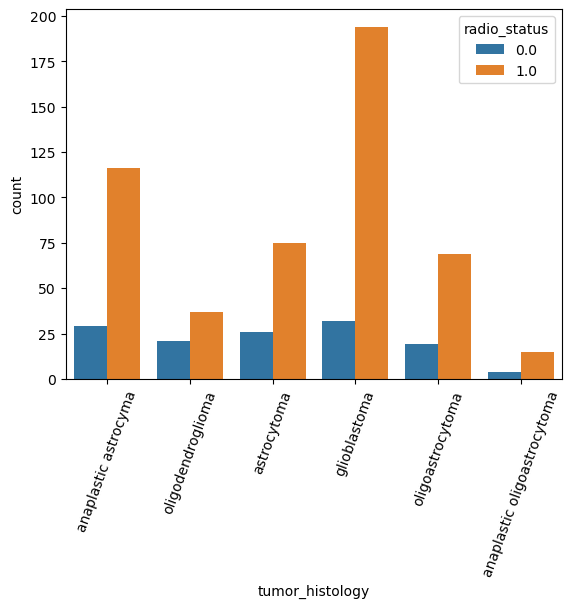

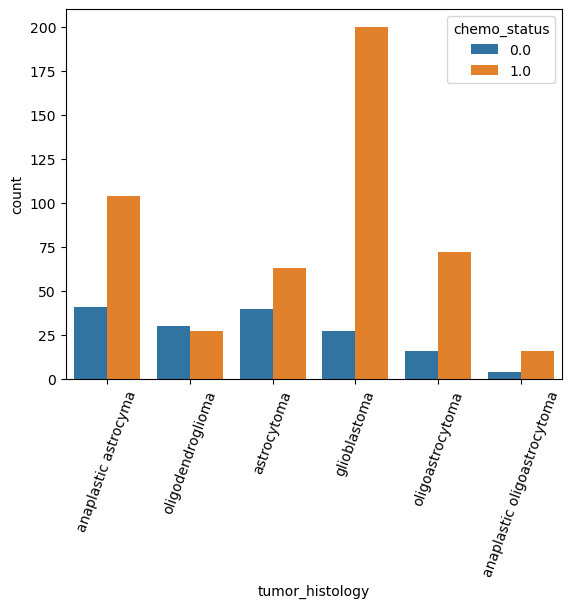

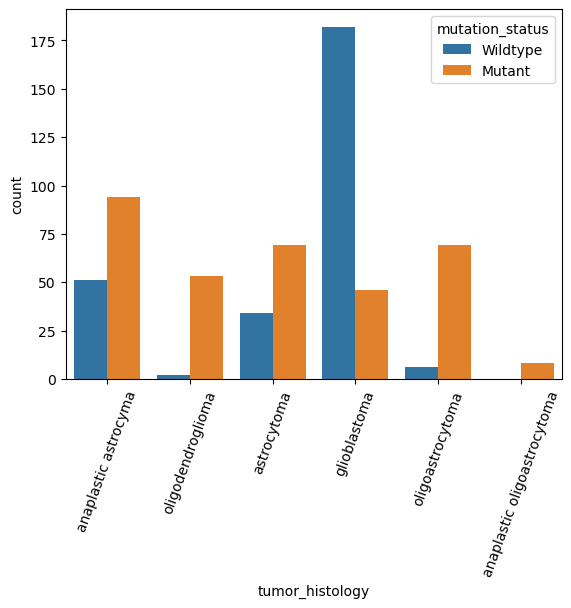

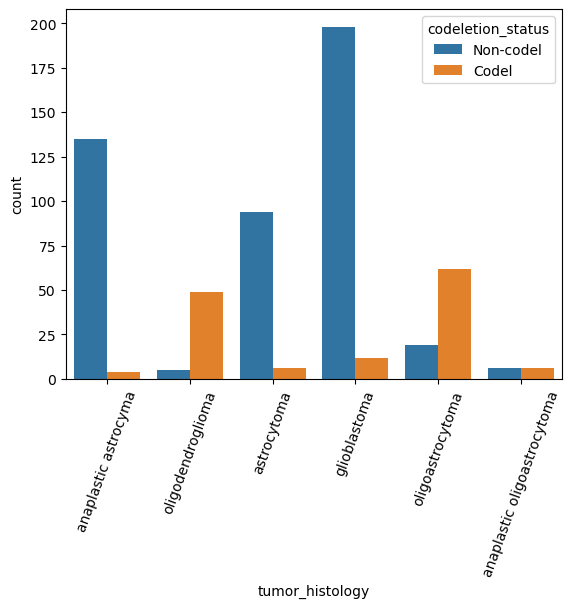

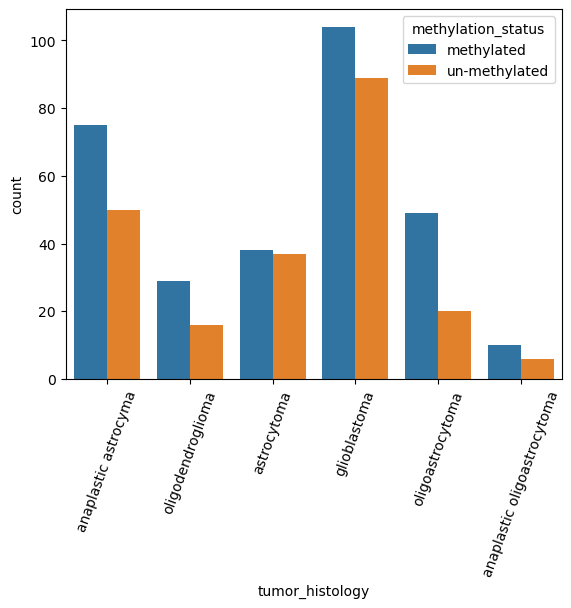

In [289]:
# check for large skews in data in terms of tumor histology and the reamining attributes
sns.countplot(x="tumor_histology", hue = "radio_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_histology", hue = "chemo_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_histology", hue = "mutation_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_histology", hue = "codeletion_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_histology", hue = "methylation_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

In [290]:
# for radio status, 2/6 of the tumor histologies are heavily skewed in terms of radio status
# impute NA values in radio status according to those 2 tumor types

df_5.loc[(df_5['tumor_histology'] == 'glioblastoma') & (pd.isna(df_5['radio_status'])), 'radio_status'] = 1
df_5.loc[(df_5['tumor_histology'] == 'anaplastic oligoastrocytoma') & (pd.isna(df_5['radio_status'])), 'radio_status'] = 1

In [291]:
# for chemo status, 2/6 of the tumor histologies are heavily skewed in terms of chemo status
# impute NA values in chemo status according to those 2 tumor types

df_5.loc[(df_5['tumor_histology'] == 'glioblastoma') & (pd.isna(df_5['chemo_status'])), 'chemo_status'] = 1
df_5.loc[(df_5['tumor_histology'] == 'anaplastic oligoastrocytoma') & (pd.isna(df_5['chemo_status'])), 'chemo_status'] = 1

In [292]:
# for mutation status, 3/6 of the tumor histologies are heavily skewed in terms of mutation status
# impute NA values in mutation status according to those 3 tumor types

df_5.loc[(df_5['tumor_histology'] == 'oligodendroglioma') & (pd.isna(df_5['mutation_status'])), 'mutation_status'] ='Mutant'
df_5.loc[(df_5['tumor_histology'] == 'oligoastrocytoma') & (pd.isna(df_5['mutation_status'])), 'mutation_status'] ='Mutant'
df_5.loc[(df_5['tumor_histology'] == 'anaplastic oligoastrocytoma') & (pd.isna(df_5['mutation_status'])), 'mutation_status'] ='Mutant'

In [293]:
# for codeletion status, 4/6 of the tumor histologies are heavily skewed in terms of codeletion status
# impute NA values in codeletion status according to those 4 tumor types

df_5.loc[(df_5['tumor_histology'] == 'anaplastic astrocyma') & (pd.isna(df_5['codeletion_status'])), 'codeletion_status'] ='Non-codel'
df_5.loc[(df_5['tumor_histology'] == 'oligodendroglioma') & (pd.isna(df_5['codeletion_status'])), 'codeletion_status'] ='Codel'
df_5.loc[(df_5['tumor_histology'] == 'astrocytoma') & (pd.isna(df_5['codeletion_status'])), 'codeletion_status'] ='Non-codel'
df_5.loc[(df_5['tumor_histology'] == 'glioblastoma') & (pd.isna(df_5['codeletion_status'])), 'codeletion_status'] ='Non-codel'


In [294]:
# check status of NA values now
print(df_5.isnull().sum())

sample_id               0
tumor_type              0
tumor_histology         0
tumor_grade             0
gender                  0
age                     0
survival_days           0
survival_status         0
radio_status           12
chemo_status           11
mutation_status        19
codeletion_status      15
methylation_status    139
dtype: int64


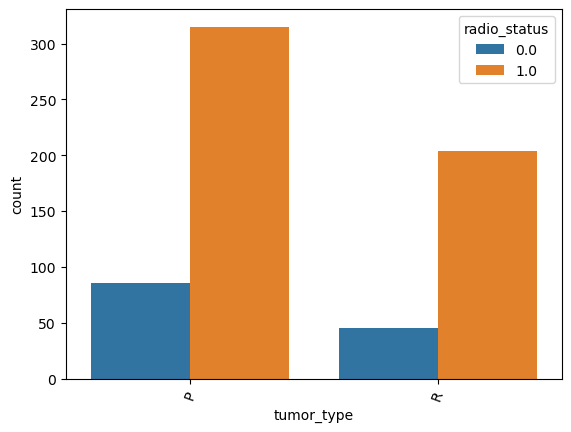

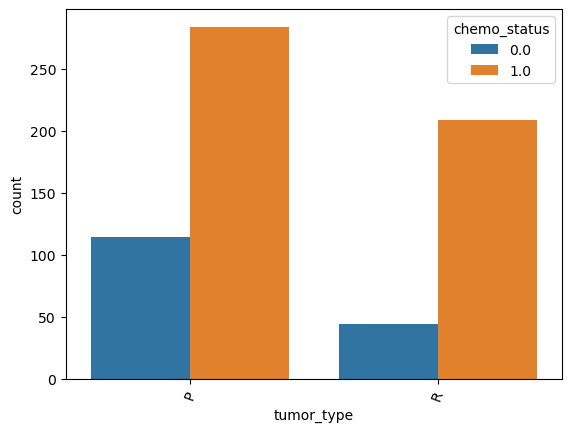

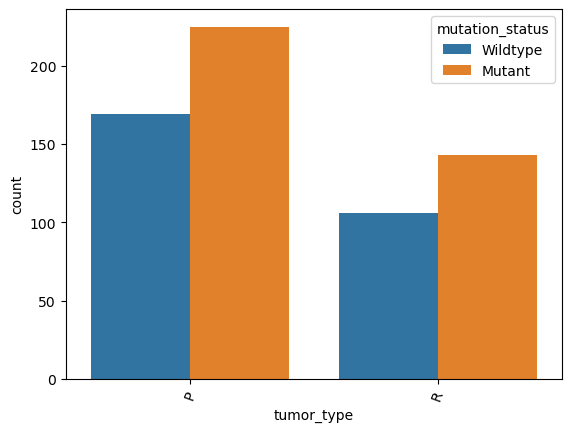

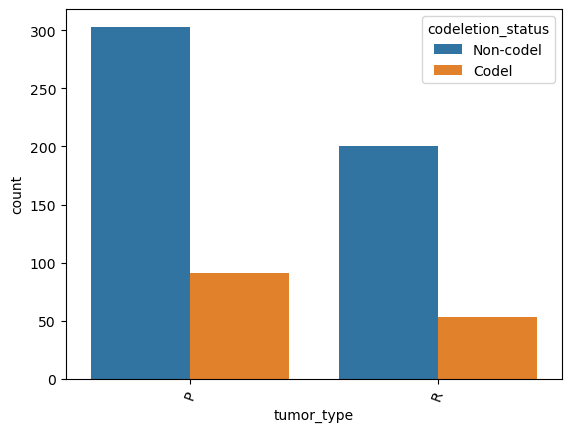

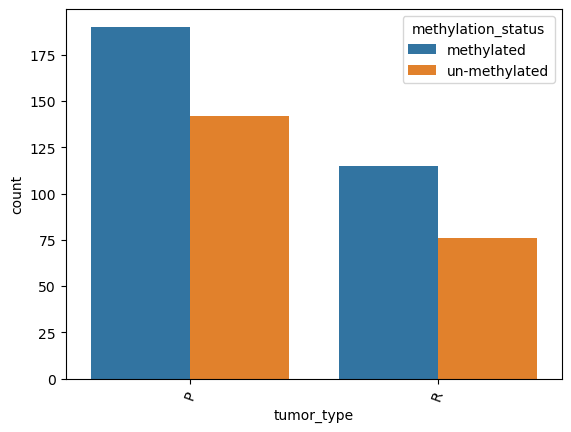

In [295]:
# check for large skews in data in terms of tumor type (reccurent vs primary) and the remaining attributes
sns.countplot(x="tumor_type", hue = "radio_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_type", hue = "chemo_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_type", hue = "mutation_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_type", hue = "codeletion_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

sns.countplot(x="tumor_type", hue = "methylation_status", data=df_5)
plt.xticks(rotation=70)
plt.show()

#plots show no significant differences to impute missing values

In [296]:
#while methylation status would be interesting to study, there is no clear skew based on tumor histology
#there is a significant amount of missing mehtylation data (139 rows)
#will drop this column and perhaps find a more complete dataset with methylation data for further study
df_5.drop('methylation_status', inplace=True, axis=1)
## axis = 0 are the rows

df_5.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,survival_days,survival_status,radio_status,chemo_status,mutation_status,codeletion_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,Non-codel
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel


In [297]:
# check status of NA values now
print(df_5.isnull().sum())

sample_id             0
tumor_type            0
tumor_histology       0
tumor_grade           0
gender                0
age                   0
survival_days         0
survival_status       0
radio_status         12
chemo_status         11
mutation_status      19
codeletion_status    15
dtype: int64


In [298]:
null_data = df_5[df_5.isnull().any(axis=1)]
null_data

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,survival_days,survival_status,radio_status,chemo_status,mutation_status,codeletion_status
9,1032,P,astrocytoma,2,F,41.0,643.0,1.0,NaN,NaN,Wildtype,Non-codel
12,1037,P,astrocytoma,2,M,44.0,780.0,0.0,1.0,0.0,NaN,Codel
15,1051,P,astrocytoma,2,M,47.0,838.0,1.0,NaN,NaN,Wildtype,Codel
38,1120,P,anaplastic oligoastrocytoma,3,F,58.0,422.0,1.0,1.0,1.0,Mutant,NaN
47,1137,P,anaplastic astrocyma,3,M,58.0,3237.0,0.0,1.0,NaN,Wildtype,Non-codel
49,1141,P,anaplastic astrocyma,3,M,65.0,432.0,1.0,NaN,NaN,Wildtype,Non-codel
55,1154,R,anaplastic astrocyma,3,F,33.0,369.0,1.0,NaN,NaN,Mutant,Non-codel
89,1239,P,oligodendroglioma,2,F,44.0,2997.0,0.0,1.0,NaN,Mutant,Codel
92,1256,P,glioblastoma,4,F,52.0,2557.0,0.0,1.0,1.0,NaN,Non-codel
104,1303,P,anaplastic oligoastrocytoma,3,F,45.0,2861.0,0.0,1.0,1.0,Mutant,NaN


In [299]:
#check number of rows with NA values
null_data.shape

(48, 12)

In [300]:
#check total number of rows remaining
df_5.shape

(662, 12)

In [301]:
## there are 48 rows remaining with NA values, many of which are missing several values
## all reasonable imputing has been performed and losing 48/662 is a reasonable action at this point
## drop remaining rows containing na values
df_5.dropna(inplace=True)
## check that no Na values remain in any column!
print(df_5.isnull().sum())

sample_id            0
tumor_type           0
tumor_histology      0
tumor_grade          0
gender               0
age                  0
survival_days        0
survival_status      0
radio_status         0
chemo_status         0
mutation_status      0
codeletion_status    0
dtype: int64


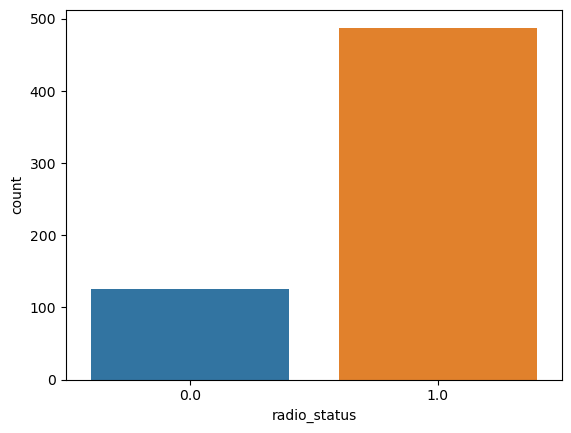

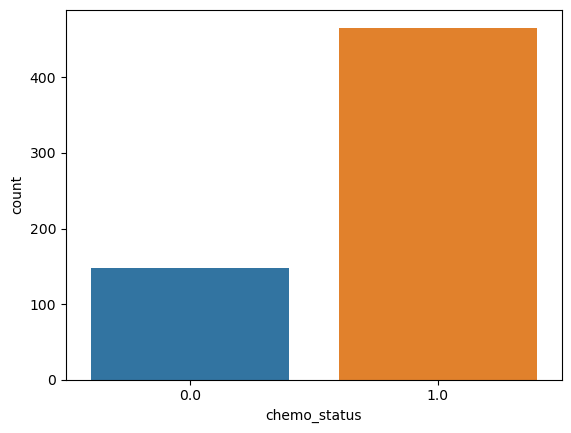

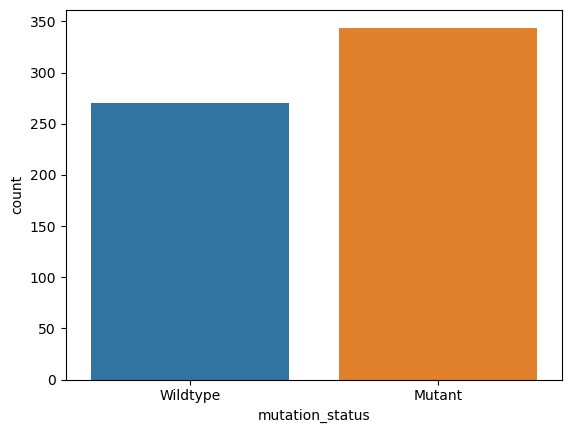

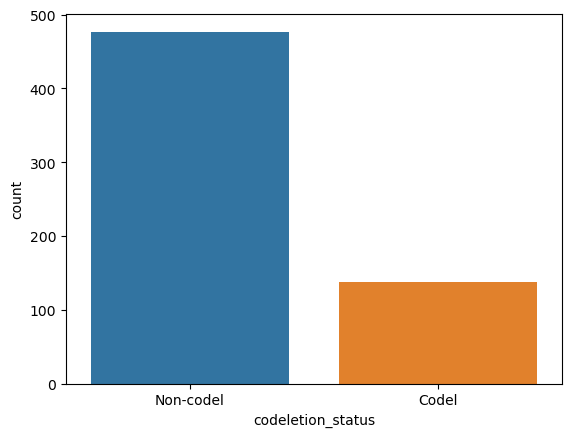

In [306]:
# final cleaning visualizations of radio, chemo, mutation and codeletion staus to check for balance and any misrecorded data
sns.countplot(data=df_5, x="radio_status")
plt.show()
sns.countplot(data=df_5, x="chemo_status")
plt.show()
sns.countplot(data=df_5, x="mutation_status")
plt.show()
sns.countplot(data=df_5, x="codeletion_status")
plt.show()


## Final notes on cleaning:

There is a skew towards tumors treated with chemo and radiation, but this is expected considering many brain cancers are life threatening and will be treated aggresively. Otherwise, the data is free of NA values and outliers. Some variables may be remapped for specific models, but for now the data is in an intuitive format and can easily be edited later.